In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/



In [ ]:
!kaggle datasets download -d utkarshsaxenadn/animal-image-classification-dataset

100% 18.8G/18.8G [10:56<00:00, 42.3MB/s]
100% 18.8G/18.8G [10:56<00:00, 30.7MB/s]


In [ ]:
import zipfile

zip_data = zipfile.ZipFile('/content/animal-image-classification-dataset.zip')
zip_data.extractall('/content')
zip_data.close()


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height = 256
img_width = 256
batch_size = 64

# Original training data
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    '/content/Training Data/Training Data',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/Testing Data/Testing Data',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Augmented training data
augmented_datagen = ImageDataGenerator(rescale=1./255)  # You can add more augmentation parameters here if needed
augmented_generator = augmented_datagen.flow_from_directory(
    '/content/Train Augmented/Train Augmented',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Custom generator to combine data from both sources
def combined_generator(train_gen, augmented_gen):
    while True:
        x1, y1 = next(train_gen)
        x2, y2 = next(augmented_gen)
        yield np.concatenate([x1, x2]), np.concatenate([y1, y2])

# Create a generator that combines both original and augmented data
combined_train_generator = combined_generator(train_generator, augmented_generator)

# Now you can use `combined_train_generator` for training, which includes data from both original and augmented sources.

# Print the number of samples in the training and augmented datasets
print("Number of samples in the original training dataset:", train_generator.samples)
print("Number of samples in the augmented training dataset:", augmented_generator.samples)


Found 30000 images belonging to 15 classes.
Found 2407 images belonging to 15 classes.
Found 150000 images belonging to 15 classes.
Number of samples in the original training dataset: 30000
Number of samples in the augmented training dataset: 150000


In [ ]:
(30000//15)

2000

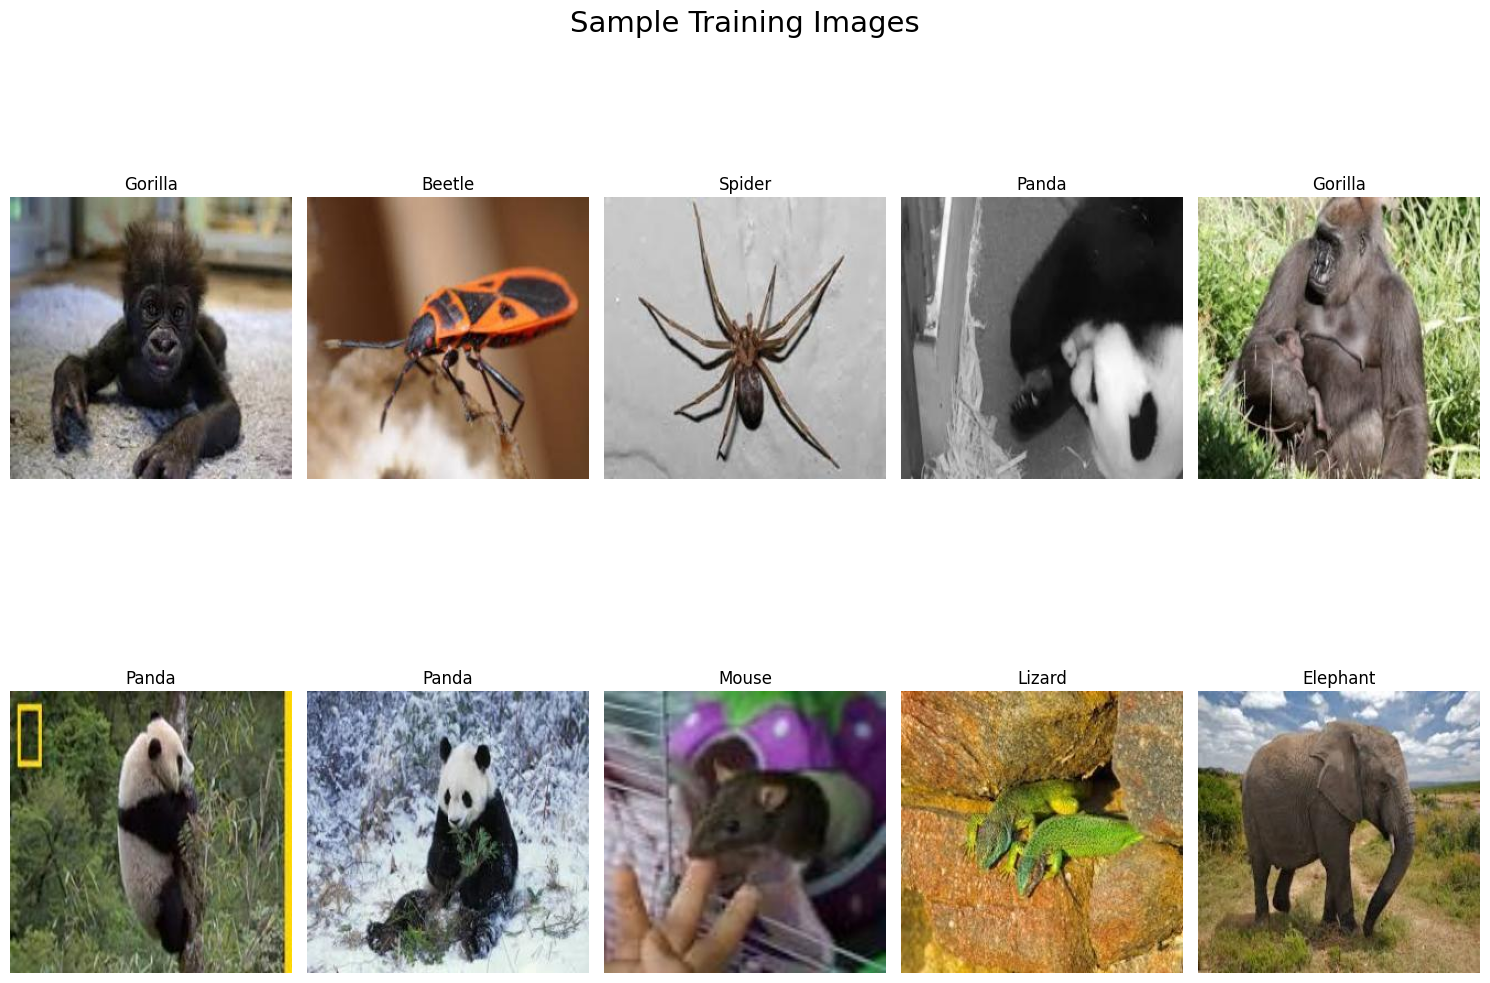

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the data generators and obtain class indices (as shown in the previous response)
# Ensure that you have already defined your train_generator and obtained class_indices.

# Define labels based on class indices
labels = {value: key for key, value in train_generator.class_indices.items()}

# Create a grid for displaying sample images
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]

        # Display the image and set the title with the class label
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

# Adjust layout and add a title
plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)

# Display the grid of images
plt.show()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import tensorflow as tf

# Initialize a Sequential model
model = Sequential()

# First Convolutional Layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Second Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Third Convolutional Layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Flatten the feature maps for the fully connected layers
model.add(Flatten())

# Fully Connected Layers
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # You can adjust the dropout rate

model.add(Dense(15, activation='softmax'))  # Output layer with 15 classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define a learning rate scheduler function
def scheduler(epoch, lr):
    if epoch < 20:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Create a learning rate scheduler callback
lr_scheduler = LearningRateScheduler(scheduler)

# Print a summary of the model architecture
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 64)      256       
 chNormalization)                                                
                                                      

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Load the VGG16 model with pretrained weights and exclude the top classification layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Initialize a Sequential model
model = Sequential()

# Add the VGG16 base model
model.add(base_model)

# Flatten the feature maps for the fully connected layers
model.add(Flatten())

# Fully Connected Layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # You can adjust the dropout rate

# Output layer with your desired number of classes (15 in your case)
model.add(Dense(15, activation='softmax'))

# Fine-tune the last few layers of the VGG16 base model
for layer in base_model.layers[:-4]:
    layer.trainable = True

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define a learning rate scheduler function
def scheduler(epoch, lr):
    if epoch < 20:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Create a learning rate scheduler callback
lr_scheduler = LearningRateScheduler(scheduler)

# Print a summary of the model architecture
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               16777728  
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 15)                7695      
                                                                 
Total params: 31500111 (120.16 MB)
Trainable params: 31500111 (120.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
import math

# Determine the number of samples in your training dataset


# Now use this value when fitting your model
model.fit(
    train_generator,

    epochs=20,
    validation_data=test_generator,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/20
469/469 [==============================] - 525s 1s/step - loss: 1.1528 - accuracy: 0.6319 - val_loss: 0.5869 - val_accuracy: 0.8164 - lr: 1.0000e-04
Epoch 2/20
469/469 [==============================] - 519s 1s/step - loss: 0.3314 - accuracy: 0.8999 - val_loss: 0.4589 - val_accuracy: 0.8650 - lr: 1.0000e-04
Epoch 3/20
469/469 [==============================] - 519s 1s/step - loss: 0.1940 - accuracy: 0.9419 - val_loss: 0.4106 - val_accuracy: 0.8749 - lr: 1.0000e-04
Epoch 4/20
469/469 [==============================] - 519s 1s/step - loss: 0.1332 - accuracy: 0.9610 - val_loss: 0.4190 - val_accuracy: 0.8866 - lr: 1.0000e-04
Epoch 5/20
469/469 [==============================] - 519s 1s/step - loss: 0.1023 - accuracy: 0.9701 - val_loss: 0.5042 - val_accuracy: 0.8600 - lr: 1.0000e-04
Epoch 6/20
469/469 [==============================] - 516s 1s/step - loss: 0.0849 - accuracy: 0.9734 - val_loss: 0.4017 - val_accuracy: 0.8990 - lr: 1.0000e-04
Epoch 7/20
469/469 [====================

# Model Accuracy and Loss

In [ ]:
# Evaluate the model on the training dataset
training_evaluation = model.evaluate(train_generator)

# This will return the loss and accuracy
training_loss = training_evaluation[0]
training_accuracy = training_evaluation[1]

print(f"Training Loss: {training_loss}")
print(f"Training Accuracy: {training_accuracy}")


469/469 [==============================] - 164s 349ms/step - loss: 0.0307 - accuracy: 0.9898
Training Loss: 0.030732758343219757
Training Accuracy: 0.9898333549499512


In [ ]:
# Evaluate the model on the test dataset
evaluation = model.evaluate(test_generator)

# This will return the loss and accuracy
test_loss = evaluation[0]
test_accuracy = evaluation[1]

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


38/38 [==============================] - 14s 357ms/step - loss: 0.4486 - accuracy: 0.8986
Test Loss: 0.4486071765422821
Test Accuracy: 0.8986290097236633


# Testing the ***model***

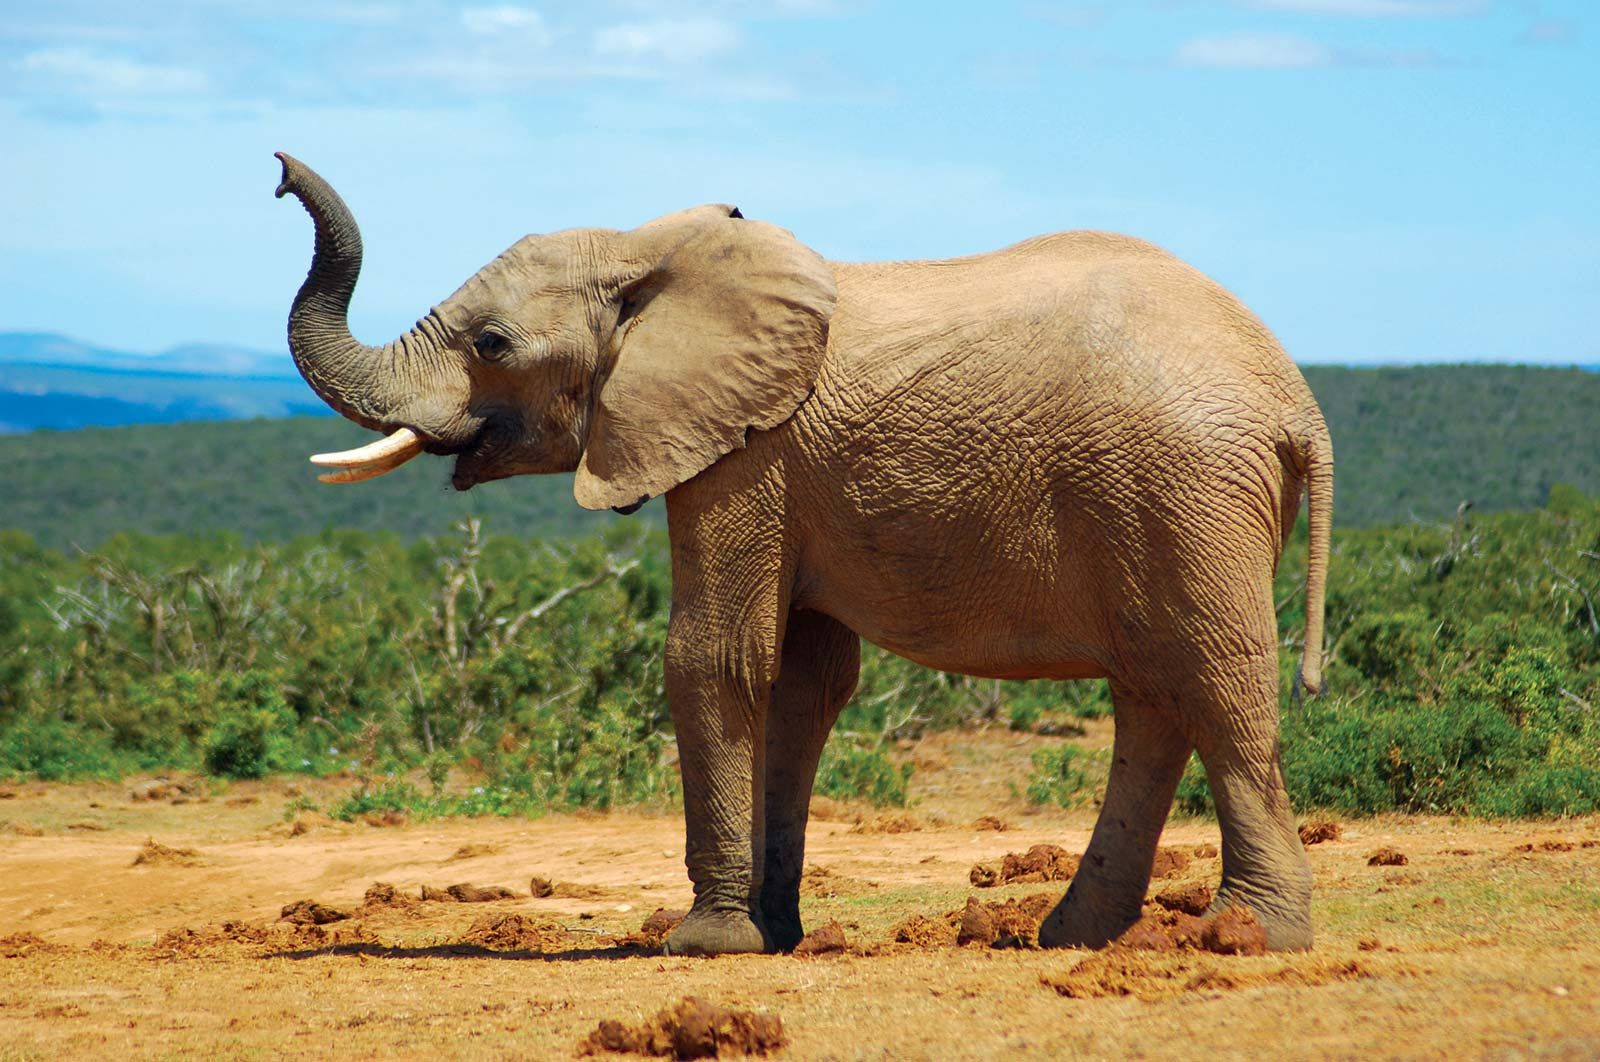

1/1 [==============================] - 0s 30ms/step
Predicted Class: Elephant


In [ ]:
import requests
from PIL import Image
from io import BytesIO

# Define the image URL
image_url = "https://cdn.britannica.com/02/152302-050-1A984FCB/African-savanna-elephant.jpg"  # Replace with the URL of the image you want to use

# Fetch the image from the URL
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))

# Display the fetched image
display(img)

# Preprocess the image
img = img.resize((img_width, img_height))  # Resize the image to match your model's input size
img = np.array(img)  # Convert the image to a NumPy array

# Expand dimensions to match the expected shape (batch size of 1)
img = np.expand_dims(img, axis=0)

# Make a prediction using your loaded model
prediction = model.predict(img)
predicted_class = np.argmax(prediction)

# Get the class label from the generator
class_label = labels[predicted_class]

# Display the predicted class
print(f'Predicted Class: {class_label}')


1/1 [==============================] - 0s 19ms/step


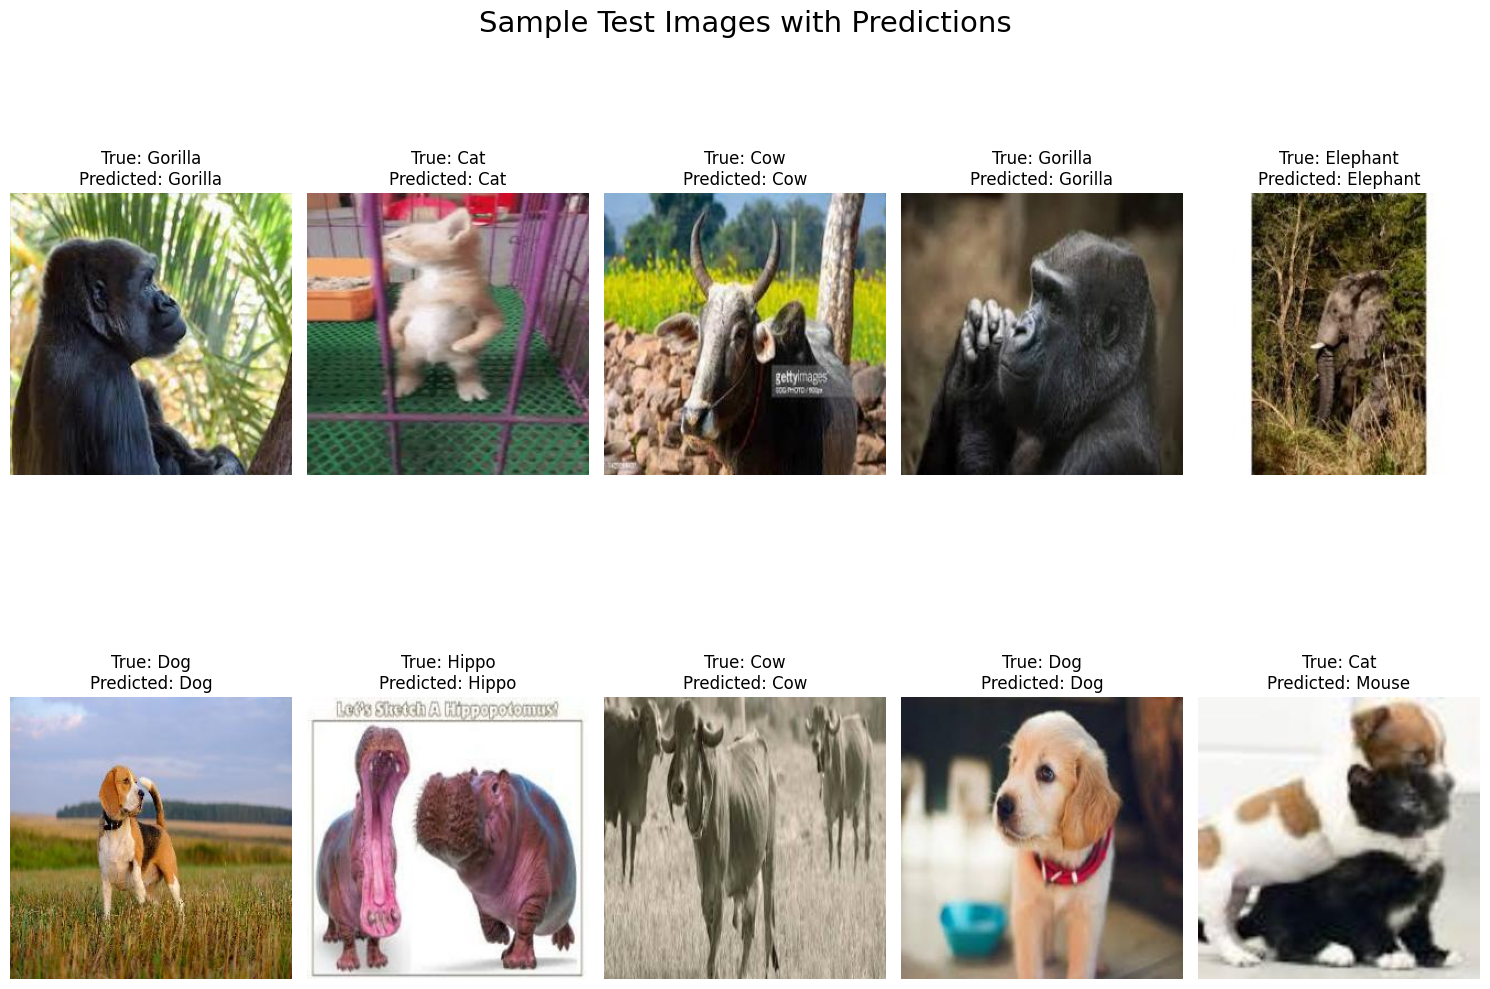

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the data generators and obtain class indices for the test dataset
# Ensure that you have already defined your test_generator and obtained class_indices.

# Define labels based on class indices
labels = {value: key for key, value in test_generator.class_indices.items()}

# Create a grid for displaying sample images
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        true_label = labels[np.argmax(test_generator[0][1][idx])]

        # Load and preprocess the image from the test dataset
        img = test_generator[0][0][idx]

        # Make a prediction using your model
        prediction = model.predict(np.expand_dims(img, axis=0))
        predicted_label = labels[np.argmax(prediction)]

        # Display the image, true label, and predicted label
        ax[i, j].set_title(f"True: {true_label}\nPredicted: {predicted_label}")
        ax[i, j].imshow(img)
        ax[i, j].axis("off")
        idx += 1

# Adjust layout and add a title
plt.tight_layout()
plt.suptitle("Sample Test Images with Predictions", fontsize=21)

# Display the grid of test images with predictions
plt.show()


README.md file successfully created!
